<a href="https://colab.research.google.com/github/jigme42/CLS_Project_Darwin2025/blob/main/climate_variation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing **libraries**

In [ ]:
# Installing and importing geemap
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        ! pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

In [ ]:
! pip install geopandas

Import **libraries**

In [ ]:
# importing libraries to be utilized
import os
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

**Initialize google earth**

In [ ]:
# initializing the google earth engine platform
ee.Authenticate()
ee.Initialize(project='ee-jthinley')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


Mount **drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
start_date='1984-01-01'
end_date='2024-12-31'
# uploading the roi shapefile
shp = gpd.read_file('/content/drive/MyDrive/CLA/aoi_export.shp')
aoi = geemap.geopandas_to_ee(shp)
Map = geemap.Map(basemap='HYBRID')
Map.addLayer(aoi, {}, 'Area of study')
Map.centerObject(aoi, 10);
Map

Map(center=[-14.99176248805695, 133.2511005338981], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# uploading  data
rainfall= ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
.filterDate(start_date, end_date)\
.filterBounds(aoi)\
.select('precipitation');


evapo_trans=ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")\
.filterDate(start_date, end_date)\
.filterBounds(aoi)\
.select('Evap_tavg')

temperature = ee.ImageCollection("MODIS/006/MOD11A2")\
.filterBounds(aoi)\
.filterDate('2000-01-01', '2024-12-31')\
.select('LST_Day_1km');

In [ ]:
# converting the modis lst from kelvin to celsius
temperature = temperature.map(lambda img: img.multiply(0.02).subtract(273.15)
                              .copyProperties(img, ['system:time_start']))


In [ ]:
# function for calculating yearly average
start_year = 2000
end_year = 2024
yearly_data=[]
def calculate_yearly_average(collection, start_year, end_year):
    yearly_data = []
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        yearly_mean = collection.filterDate(start_date, end_date).mean()
        mean_dict = yearly_mean.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        yearly_data.append(mean_dict.getInfo())
        yearly_data[-1]['year'] = year

    return pd.DataFrame(yearly_data)


In [ ]:
#calculate yearly sum for rainfall
def calculate_yearly_sum(collection, start_year, end_year):
    yearly_data = []
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        yearly_sum = collection.filterDate(start_date, end_date).sum()
        mean_dict = yearly_sum.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        yearly_data.append(mean_dict.getInfo())
        yearly_data[-1]['year'] = year

    return pd.DataFrame(yearly_data)

In [ ]:
rainfall_df = calculate_yearly_sum(rainfall, start_year, end_year)
evapo_trans_df = calculate_yearly_average(evapo_trans, start_year, end_year)
temperature_df = calculate_yearly_average(temperature, start_year, end_year)

In [ ]:
yearly_climate_df = pd.DataFrame({
    'year': rainfall_df['year'],
    'rainfall': rainfall_df['precipitation'],
    'evapotranspiration': evapo_trans_df['Evap_tavg'],
    'temperature': temperature_df['LST_Day_1km']
})

In [ ]:
yearly_climate_df

,year,rainfall,evapotranspiration,temperature
0,2000,1178.538449,0.000029,34.090149
1,2001,1004.672893,0.000030,35.734080
2,2002,767.215368,0.000024,36.897070
3,2003,1305.751233,0.000026,36.248147
4,2004,1257.996416,0.000027,35.268419
5,2005,769.964648,0.000024,36.615984
6,2006,997.794434,0.000028,34.784887
7,2007,981.611918,0.000026,35.886889
8,2008,1111.900133,0.000026,36.036237
9,2009,964.686317,0.000025,36.060687


Plot **precipitation**

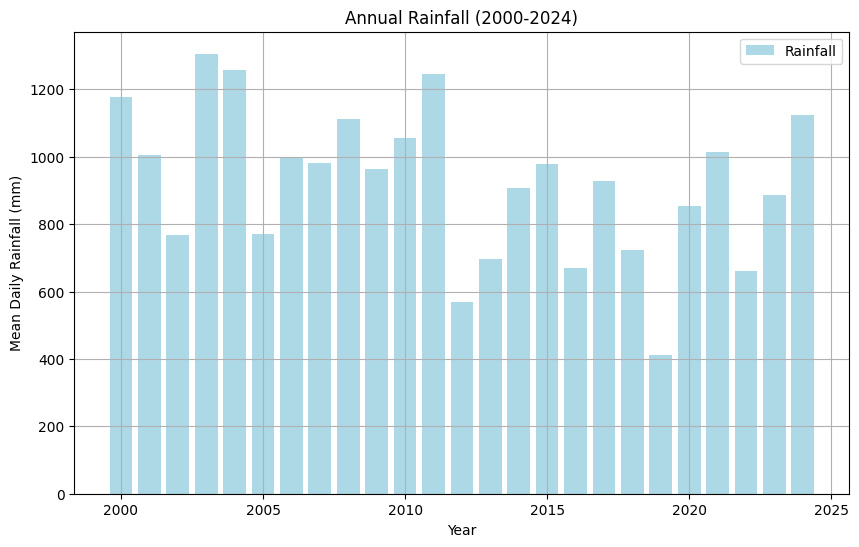

In [ ]:
# Plot the yearly rainfall trens trends
plt.figure(figsize=(10, 6))
plt.bar(yearly_climate_df['year'], yearly_climate_df['rainfall'], label='Rainfall', color='lightblue')
plt.xlabel('Year')
plt.ylabel('Mean Daily Rainfall (mm)')
plt.title('Annual Rainfall (2000-2024)')
plt.legend()
plt.grid(True)
plt.show()

Plot **temperature**

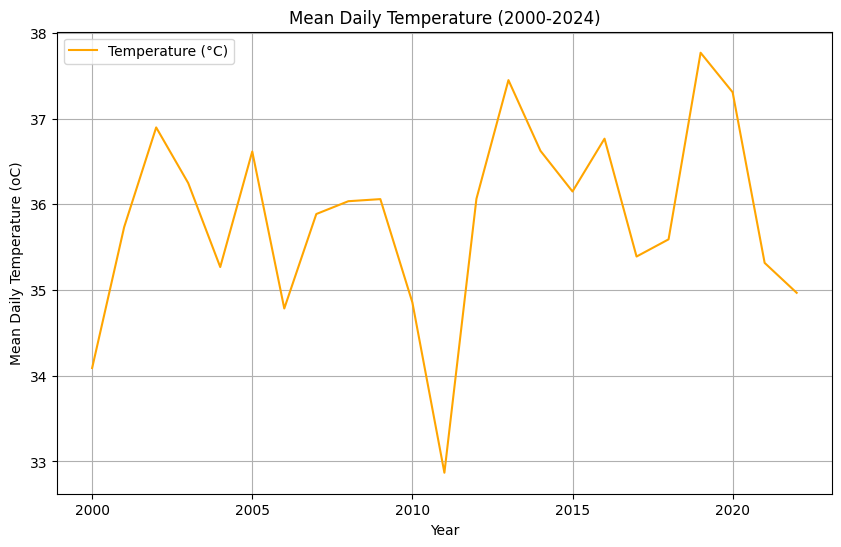

In [ ]:
# Plot the yearly temperature trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_climate_df['year'], yearly_climate_df['temperature'], label='Temperature (°C)', color='orange')
plt.xlabel('Year')
plt.ylabel('Mean Daily Temperature (oC)')
plt.title('Mean Daily Temperature (2000-2024)')
plt.legend()
plt.grid(True)
plt.show()

Plot **evapotranspiration**

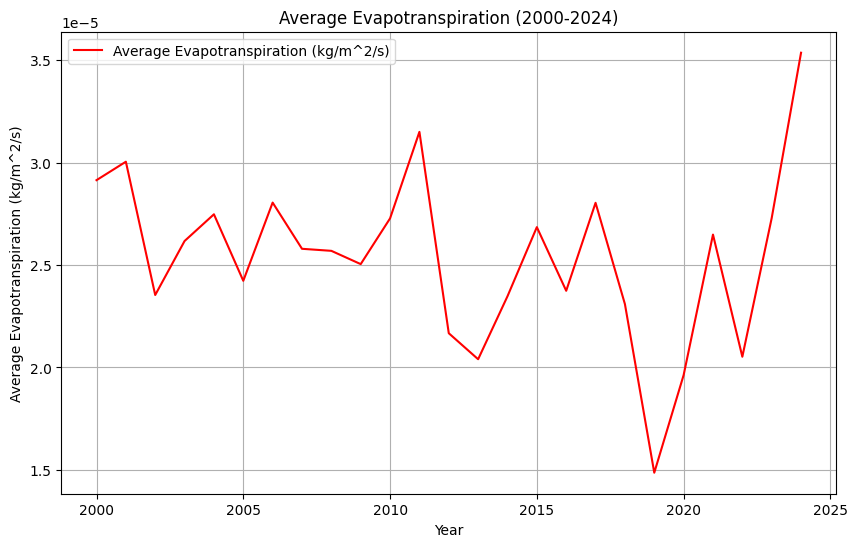

In [ ]:
# Plot the yearly evapotranspirationtrends
plt.figure(figsize=(10, 6))
plt.plot(yearly_climate_df['year'], yearly_climate_df['evapotranspiration'], label='Average Evapotranspiration (kg/m^2/s)', color='red')
plt.xlabel('Year')
plt.ylabel('Average Evapotranspiration (kg/m^2/s)')
plt.title('Average Evapotranspiration (2000-2024)')
plt.legend()
plt.grid(True)
plt.show()